#**Install & Update**

In [ ]:
!pip install -Uq segmentation-models-pytorch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 565.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 625.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 983.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 998.9 kB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

# Data & Visualization
### Note: brighter the area, farther it is in the image, brighter => more depth
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d soumikrakshit/nyu-depth-v2

100% 4.10G/4.10G [00:45<00:00, 80.2MB/s]
100% 4.10G/4.10G [00:45<00:00, 95.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nyu-depth-v2.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_csv = Path('/content/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/content/nyu_data/data/nyu2_train')
base_path = Path('/content/nyu_data')

In [ ]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

0  \
0  /content/nyu_data/data/nyu2_train/living_room_...   
1  /content/nyu_data/data/nyu2_train/living_room_...   
2  /content/nyu_data/data/nyu2_train/living_room_...   
3  /content/nyu_data/data/nyu2_train/living_room_...   
4  /content/nyu_data/data/nyu2_train/living_room_...   

                                                   1  
0  /content/nyu_data/data/nyu2_train/living_room_...  
1  /content/nyu_data/data/nyu2_train/living_room_...  
2  /content/nyu_data/data/nyu2_train/living_room_...  
3  /content/nyu_data/data/nyu2_train/living_room_...  
4  /content/nyu_data/data/nyu2_train/living_room_...

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

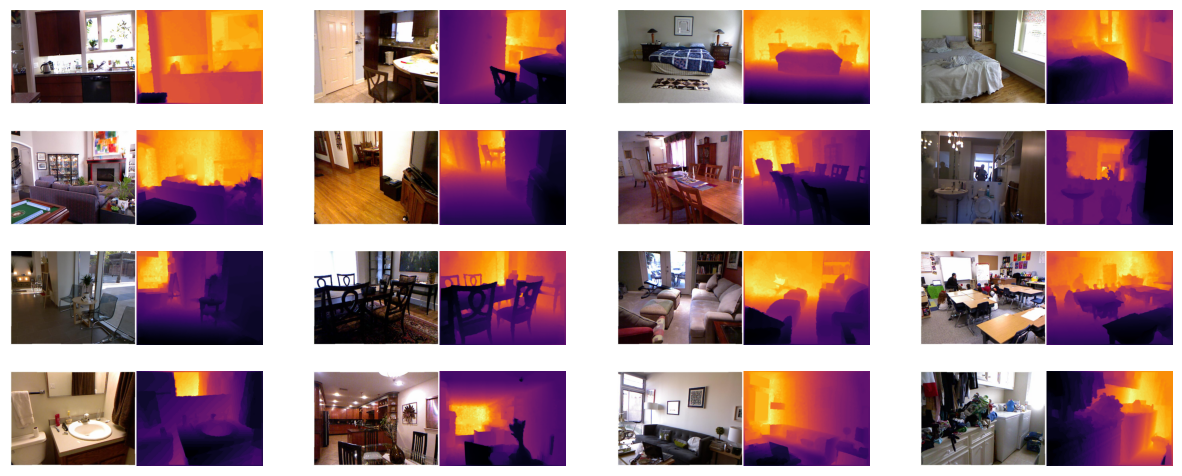

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset
<div style="width:100%;height:0;border-bottom: 3px solid #F7F437;margin-bottom: 1rem;"></div>


In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [ ]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [ ]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

# Transforms Visualization
<div style="width:100%;height:0;border-bottom: 3px solid #DEF839;margin-bottom: 1rem;"></div>

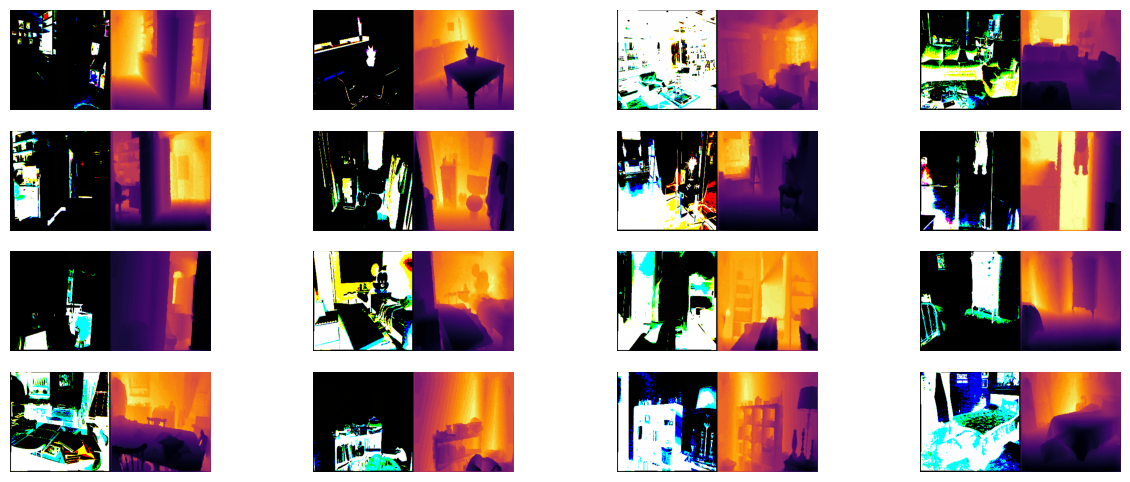

In [ ]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

# Model
<div style="width:100%;height:0;border-bottom: 3px solid #C3F93B;margin-bottom: 1rem;"></div>

In [ ]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )

    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable

    def forward(self,x):
        return self.model(x)

    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

# Multiscale Structural Similarity Index (MS-SSIM)

<div style="width:100%;height:0;border-bottom: 3px solid #F59A31;margin-bottom: 1rem;"></div>

### Metrics:

#### Multiscale Structural Similarity Index (MS-SSIM)

The Multiscale Structural Similarity Index (MS-SSIM) is an extension of the Structural Similarity Index (SSIM) that incorporates multiple scales to capture both local and global image information more effectively. MS-SSIM operates by decomposing images into multiple scales using a series of low-pass filters and downsampling operations, allowing it to analyze image structures at different resolutions.

The MS-SSIM index is calculated based on comparing the luminance, contrast, and structure similarity at each scale, and then combining these similarities into a final score. This multi-scale approach enables MS-SSIM to better account for perceptual differences between images, making it a more accurate metric for image quality assessment compared to SSIM alone.

The formula for MS-SSIM involves computing SSIM values at multiple scales and combining them using a weighted average. It can be represented as:

$$ MS\_SSIM = \left( \prod_{i=1}^{N} \left( SSIM_i \right)^{\alpha_i} \right)^{\beta} $$

where $SSIM_i$ represents the SSIM value at scale $i$, $\alpha_i$ is a weight factor for each scale, and $\beta$ is a normalization factor to ensure the final score is within a bounded range.

MS-SSIM provides a more comprehensive assessment of image quality by considering both local and global features across multiple scales, making it particularly useful in applications where perceptual fidelity is critical, such as image compression, super-resolution, and image restoration.

In summary, MS-SSIM extends the capabilities of SSIM by incorporating multi-scale analysis, resulting in a more robust and accurate metric for evaluating the similarity between images.

In [ ]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [ ]:
pip install pytorch-msssim

In [ ]:
pip install --upgrade pytorch-msssim

In [ ]:
from torchmetrics import Metric

class MSSSIM(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("msssim", default=torch.tensor(0.0), dist_reduce_fx="mean")

    def update(self, preds, target):
        self.msssim += ms_ssim(preds, target)

    def compute(self):
        return self.msssim

epochs = 1
freeze_epochs = 2
lr = 1e-3

device = 'cuda'

from torchvision.models import densenet121
from pytorch_msssim import ssim, ms_ssim

metrics = MetricCollection([
    MSSSIM(),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','msssim_train','msssim_val','mse_train','mse_val']]=None

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

training decoder only


epoch 0, loss: 0.010: 100%|██████████| 713/713 [31:12<00:00,  2.63s/it]

epoch 0, loss: 0.006: 100%|██████████| 72/72 [01:22<00:00,  1.15s/it]




  loss_train loss_val msssim_train msssim_val mse_train  mse_val
0   0.024594  0.00628   712.912842   72.00428  0.024598  0.00628




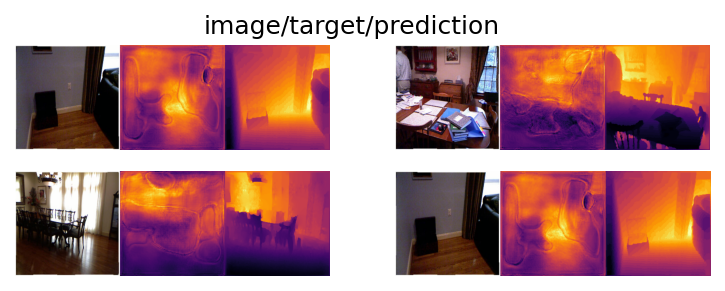

100%|██████████| 1/1 [32:37<00:00, 1957.42s/it]


In [ ]:
best_msssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))

    for img, mask in train_prog:

        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'epoch {epoch}, loss: {loss.item():.3f}')  # Set the epoch number along with the loss
            train_metrics(preds,mask)

        del img, mask, preds, loss

    m = train_metrics.compute()
    _msssim,_mse = m['MSSSIM'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','msssim_train','mse_train']] = (running_loss/len(train_dl),_msssim,_mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'epoch {epoch}, loss: {loss.item():.3f}')  # Set the epoch number along with the loss

                val_metrics(preds, mask)

            del img, mask, preds, loss

        m = val_metrics.compute()
        _msssim,_mse = m['MSSSIM'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','msssim_val','mse_val']] = (running_loss/len(val_dl),_msssim,_mse)
        val_metrics.reset()

    if _msssim > best_msssim:
        best_msssim = _msssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')

    print(f"\n\n{logs.tail(1)}\n\n")

    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )

    gc.collect()
    torch.cuda.empty_cache()


# Predictions
<div style="width:100%;height:0;border-bottom: 3px solid #F7D735;margin-bottom: 1rem;"></div>

In [ ]:
best_epoch

0

In [ ]:
best_sd = torch.load('/content/nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')
model.load_state_dict(best_sd)

<All keys matched successfully>

100%|██████████| 127/127 [00:07<00:00, 16.09it/s]


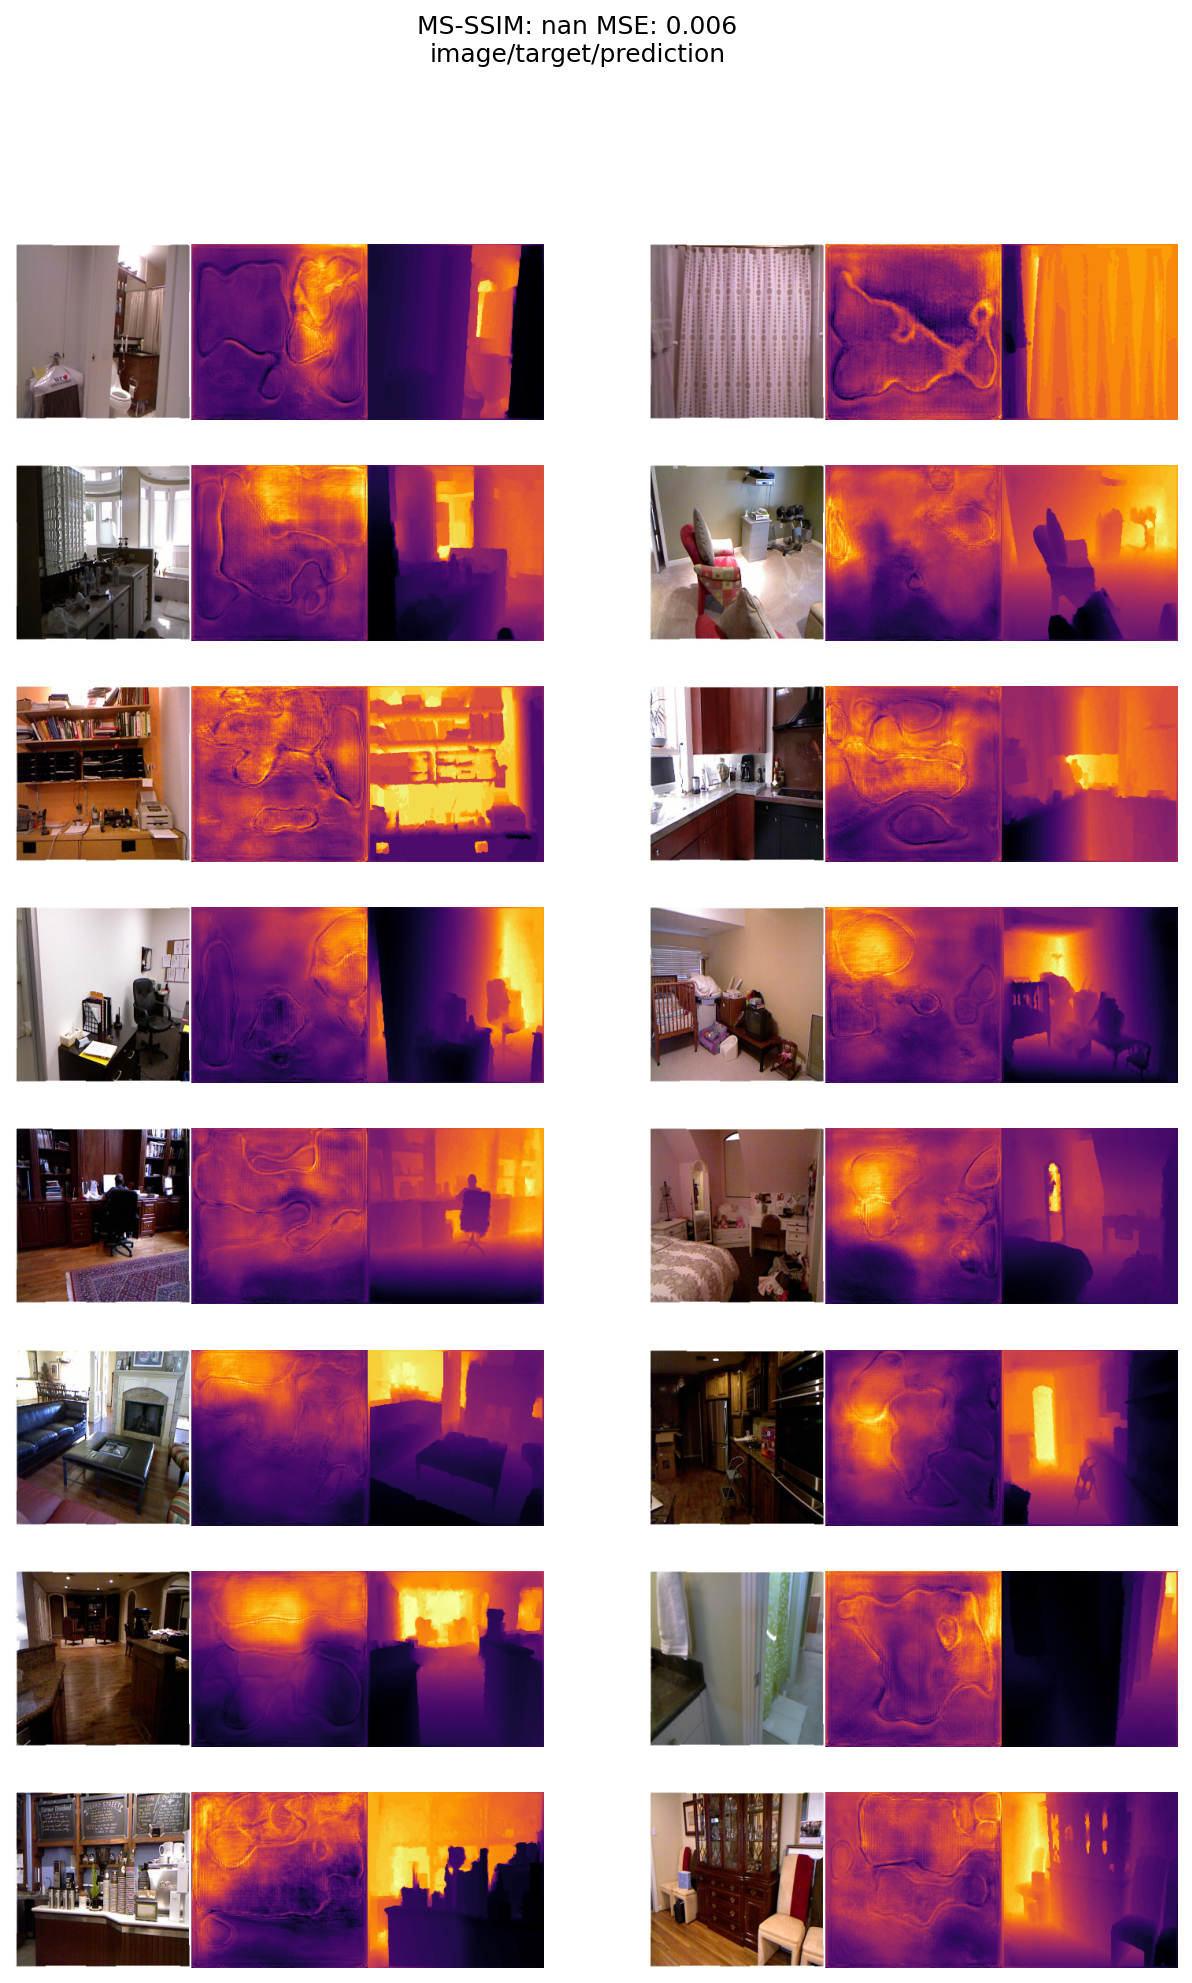

In [ ]:
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast

ms_ssim_value = m.get('MS_SSIM', float('nan'))

# Create title using MS-SSIM value
title = f"MS-SSIM: {ms_ssim_value:.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"

with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl, total=len(test_dl)):
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds.float())  # Convert to full precision
            all_targets.append(mask)

test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()

# Create title with error handling for KeyError
ms_ssim_value = m.get('MS_SSIM', float('nan'))
title = f"MS-SSIM: {ms_ssim_value:.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"

plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10, 15),
    title=title
)


# Results
<div style="width:100%;height:0;border-bottom: 3px solid #8DFA3F;margin-bottom: 1rem;"></div>

In [ ]:
logs

loss_train loss_val msssim_train msssim_val mse_train  mse_val
0   0.024594  0.00628   712.912842   72.00428  0.024598  0.00628

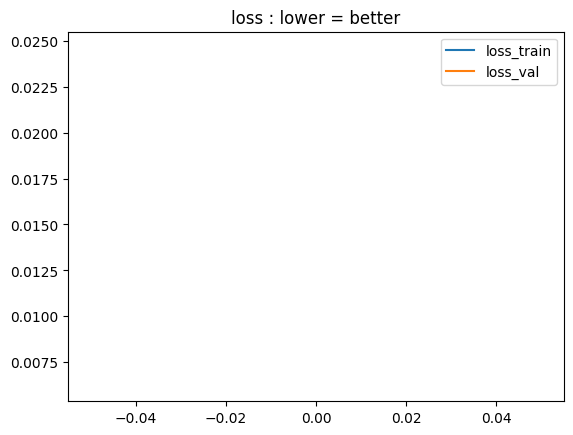

In [ ]:
logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

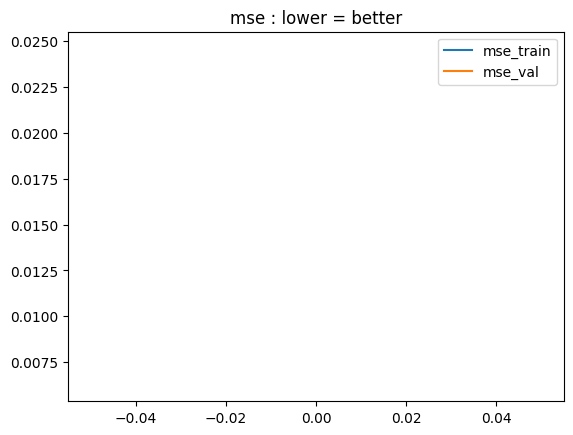

In [ ]:
logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

In [ ]:
print(logs.keys())

Index(['loss_train', 'loss_val', 'msssim_train', 'msssim_val', 'mse_train',
       'mse_val'],
      dtype='object')


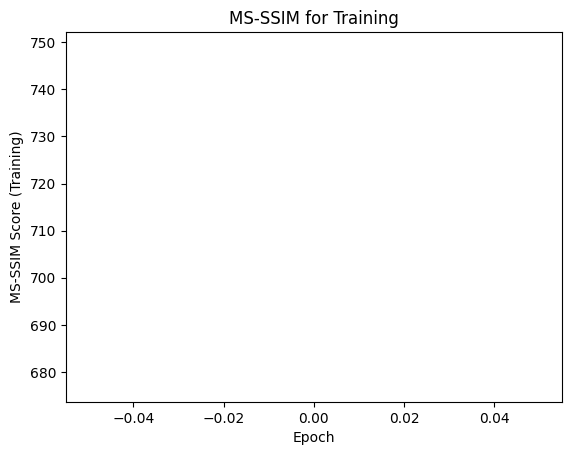

In [ ]:
import matplotlib.pyplot as plt

# Plot MS-SSIM for training
logs['msssim_train'].plot()

plt.title('MS-SSIM for Training')
plt.xlabel('Epoch')
plt.ylabel('MS-SSIM Score (Training)')
plt.show()
